In [136]:
import numpy as np
import matplotlib.pyplot as plt

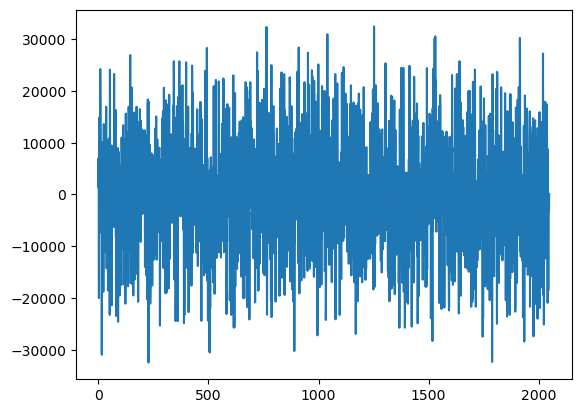

In [137]:
wave = np.fromfile('calibrator_231001.bin' ,dtype=np.int16)
plt.plot(wave)

In [138]:
Ns = len(wave) # basic waveform length
Nx = 16 # number of repetitions we want to generate
Npt = Ns * Nx # total length

In [139]:
# first way of doing it, is simply stacking the waveforms 8 times
wave_total_1 = np.hstack((wave,)*Nx)
print(wave_total_1)
print(len(wave_total_1))
assert(wave_total_1.shape == (Npt,))

[ 1456  6990   570 ... -2435 -3351   117]
32768


In [140]:
# Now we are going to do the same in very complicated way, that will enable us to instute time delays without interpolations
# First we will transform the waveform into Fourier space and then generate the extended waveforms using "tones"

wave_f = np.fft.rfft(wave)
freqs = np.fft.rfftfreq(Ns)
phi = np.arange(Npt)*2*np.pi/Ns
wave_total_2 = np.zeros(Npt, dtype=complex)
for freq, comp in enumerate(wave_f):
    # add to wave_total_2 the component at frequency freq
    wave_total_2 += 2 * comp * np.exp(1j * phi * (freqs[freq] * Ns)) / Ns

wave_total_2 = np.real(wave_total_2)

float_formatter = "{:5.0f}".format
np.set_printoptions(formatter={'float_kind': float_formatter})  # format print for easier comparison
print(f"Stacked: \n\t{wave_total_1}")
print(f"FFT: \n\t{wave_total_2}")

# Check equality
difference = np.abs(wave_total_1 - wave_total_2)
print(f"\nMax difference:", np.max(difference))
print("Mean difference:", np.mean(difference))
print("Standard deviation of difference:", np.std(difference))

assert(np.allclose(wave_total_1, wave_total_2))


Stacked: 
	[ 1456  6990   570 ... -2435 -3351   117]
FFT: 
	[ 1456  6990   570 ... -2435 -3351   117]

Max difference: 2.524884621379897e-07
Mean difference: 1.960423546719034e-08
Standard deviation of difference: 2.2939277124437528e-08


In [141]:
# Now turn the above into a function that can generate the waveform with arbirary clock drifts (f -> f*(1+clock_drift))

# Generate a large Nx waveform with Nx of 100000 or something.

# Write a function that pulls a single tone from this waveform using fft->pick up just coefficients aronud the frequency of interest --> fft back

# Use your previous code to fit the parameters of this tone, see if you can get the frequency and amplitude right

In [142]:
# part 1: function with adjustable clock drifts and Nx
# same process, small tweaks to meet new goals
def drifted_signal(clock_drift=0, nx=100000):  # for nx different than original Nx=16
    signal_drift = np.zeros(Ns * nx, dtype=complex)
    phi_shift = np.arange(Ns * nx) * 2 * np.pi / Ns

    for f, coef in enumerate(wave_f):
        # add to drifted_wave the component at frequency f
        signal_drift += 2 * coef * np.exp(1j * phi_shift * f * (1 + clock_drift)) / Ns
    signal_drift = np.real(signal_drift)
    return signal_drift


# adjust as necessary, can easily be changed to respond to user input rather than a manually set value
drift = 1e-6
print(f"Drifted by {drift}: \n\t{drifted_signal(drift, 16)}")


Drifted by 1e-06: 
	[ 1456  6990   570 ... -2060 -3641   531]


In [143]:
# part 2: pick up coefficients around frequency of interest

def isolate_frequency(f, signal):
    coefs = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal))

    index = np.abs(freqs - f).argmin()

    x_ind = np.sum(signal * np.exp(-1j * 2 * np.pi * index * np.arange(len(signal)) / len(signal)))

    A = np.zeros(len(coefs), dtype=complex)
    A[index] = x_ind

    non_zero_freqs = [i for i in range(len(A)) if A[i] != 0]

    # debug info
    print(f"Desired frequency: {f}")
    print(f"Frequency closest to desired frequency: {freqs[index]}")
    print(f"Index of the closest frequency: {index}")
    print(f"Indices of non-zero frequencies: {non_zero_freqs}")

    return np.fft.irfft(A)


In [144]:
isolated_signal = isolate_frequency(0.4898, wave)

Desired frequency: 0.4898
Frequency closest to desired frequency: 0.48974609375
Index of the closest frequency: 1003
Indices of non-zero frequencies: [1003]


In [145]:
# check frequency is what we asked for
def analyze_frequency(signal):
    N = len(signal)
    freqs = np.fft.rfftfreq(N)
    fft_vals = np.fft.rfft(signal)
    peak_freq = freqs[np.argmax(np.abs(fft_vals))]
    return peak_freq


peak_frequency = analyze_frequency(isolated_signal)
print(f"Primary frequency of the new signal: {peak_frequency}")


Primary frequency of the new signal: 0.48974609375


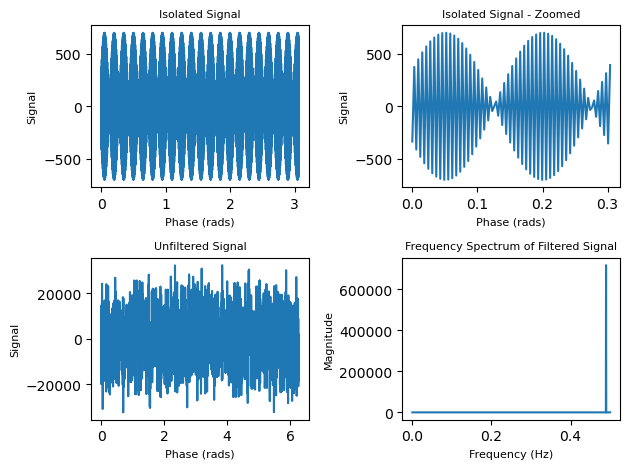

In [146]:
# there is a problem with the irfft output... there is some group frequency that i can't make
# go away without messing with the desired frequency and i don't see where it's coming from

plt.subplot(2, 2, 1)
plt.plot(phi[:1000], isolated_signal[:1000])
plt.title('Isolated Signal', fontsize=8)
plt.xlabel('Phase (rads)', fontsize=8)
plt.ylabel('Signal', fontsize=8)

plt.subplot(2, 2, 2)
plt.plot(phi[:100], isolated_signal[:100])
plt.title('Isolated Signal - Zoomed', fontsize=8)
plt.xlabel('Phase (rads)', fontsize=8)
plt.ylabel('Signal', fontsize=8)

plt.subplot(2, 2, 3)
plt.plot(phi[:len(wave)], wave)
plt.title('Unfiltered Signal', fontsize=8)
plt.xlabel('Phase (rads)', fontsize=8)
plt.ylabel('Signal', fontsize=8)

plt.subplot(2, 2, 4)
plt.plot(np.fft.rfftfreq(len(isolated_signal)), np.abs(np.fft.rfft(isolated_signal)))
plt.title('Frequency Spectrum of Filtered Signal', fontsize=8)
plt.xlabel('Frequency (Hz)', fontsize=8)
plt.ylabel('Magnitude', fontsize=8)
plt.tight_layout()
plt.show()